In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import tensorflow as tf

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/energydata_complete.csv")

In [3]:
ts = df["Appliances"]

In [4]:
ts.head()

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64

In [5]:
dates = pd.to_datetime(df.date)

In [6]:
series = np.asarray(ts.values)

In [7]:
time = np.arange(series.shape[0])

In [8]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

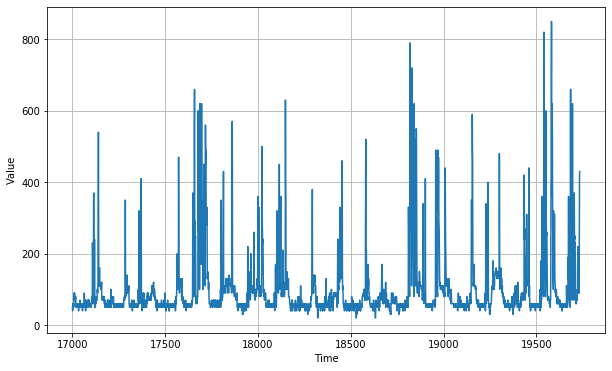

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time, series, start = 17000)
plt.show()

* We can observe some patterns, maybe some seasonality or cycle.

In [10]:
split_time = int(series.shape[0] * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [11]:
series

array([ 60,  60,  50, ..., 270, 420, 430])

## Naive Forecast

In [12]:
naive_forecast = series[split_time - 1: -1]

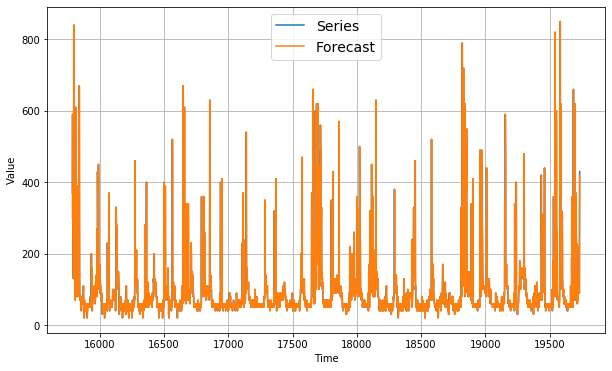

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")
plt.show()

* It looks like we nailed it, but lets zoom in on the start

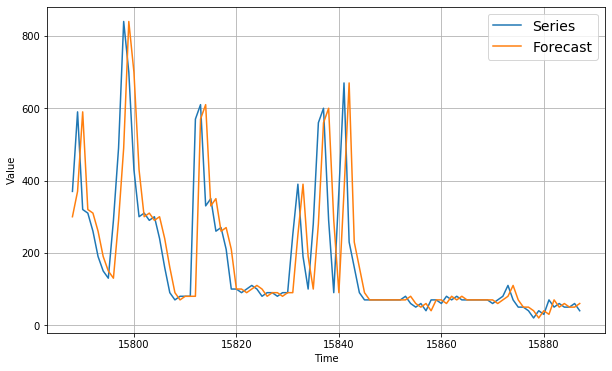

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=100, label="Series")
plot_series(time_valid, naive_forecast, start=0, end=100, label="Forecast")

* We just replicated the result of the previous day (shifted). It seems to be a good start.

In [15]:
tf.keras.metrics.mse(x_valid, naive_forecast).numpy()

4413

In [16]:
tf.keras.metrics.mae(x_valid, naive_forecast).numpy()

26

## Moving Average 30 days

In [17]:
def moving_average(series, window_size):
    forecast = []
    for time in range(len(series) - window_size): # if you dont subtract the window size, you'll not compute right in the last 30 examples
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [18]:
moving_avg = moving_average(series, 30)

In [19]:
moving_avg.shape

(19705,)

In [20]:
x_valid.shape

(3947,)

* the moving_avg must be taken for the period of the x_valid as comparison

In [21]:
moving_avg = moving_avg[split_time - 30:]

In [22]:
moving_avg.shape #now its ok

(3947,)

* Comparing

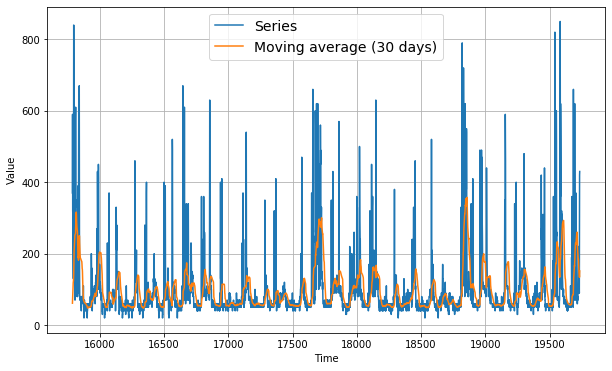

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [24]:
tf.keras.metrics.mse(x_valid, moving_avg).numpy()

7023.8004673028745

In [25]:
tf.keras.metrics.mae(x_valid, moving_avg).numpy()

43.03943923655096

* Results were worse than the naive approach

## Moving Average 5 days

In [26]:
moving_avg_5 = moving_average(series, 5)[split_time - 5:]

In [27]:
moving_avg_5.shape

(3947,)

In [28]:
x_valid.shape

(3947,)

* Comparing

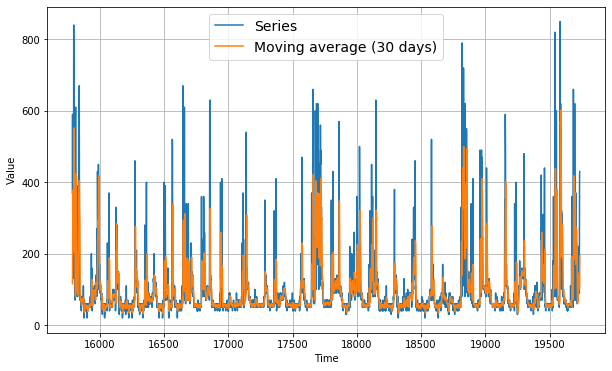

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg_5, label="Moving average (30 days)")

In [30]:
tf.keras.metrics.mse(x_valid, moving_avg_5).numpy()

5607.859133519129

In [31]:
tf.keras.metrics.mae(x_valid, moving_avg_5).numpy()

33.453762351152776

* Better but still worse than the naive approach

## Differencing

* As we have 10 min spaced data, we should have 144 instances per day, just to confirm :

In [32]:
dates.loc[(dates.dt.year == 2016) & (dates.dt.day == 12) & (dates.dt.month == 1)].shape

(144,)

* In this approach we will subtract the values at time t, from the values at time t - 144

In [33]:
diff_series = (series[144:] - series[:-144])

In [34]:
diff_time = time[144:]

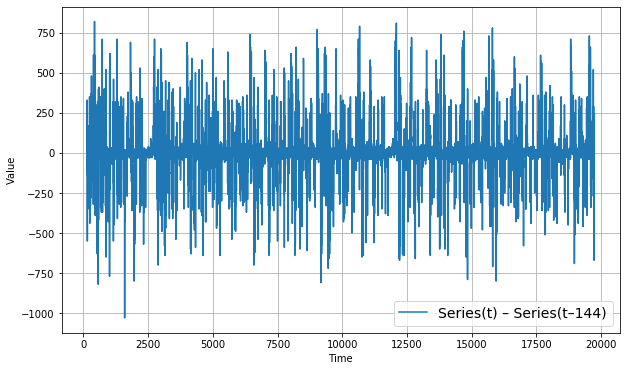

In [35]:
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–144)")
plt.show()

In [36]:
print(x_valid.shape)
print(diff_series[split_time:].shape)

(3947,)
(3803,)


* we have to subtract 144 from the split time in diff_series, since it is 144 spaces shorter than the original one, because we didnt compute this subtraction for the first 144 values

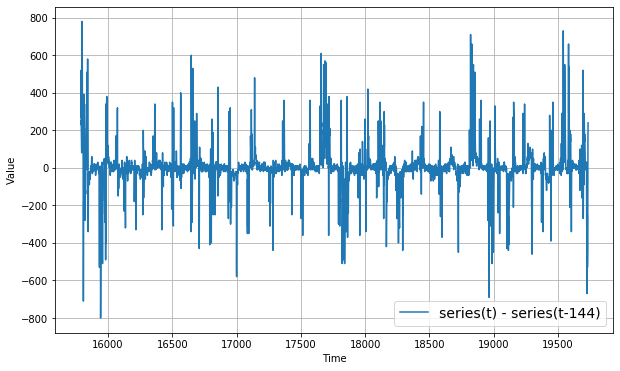

In [37]:
plt.figure(figsize=(10,6))
plot_series(time_valid, diff_series[split_time - 144:], label = "series(t) - series(t-144)")

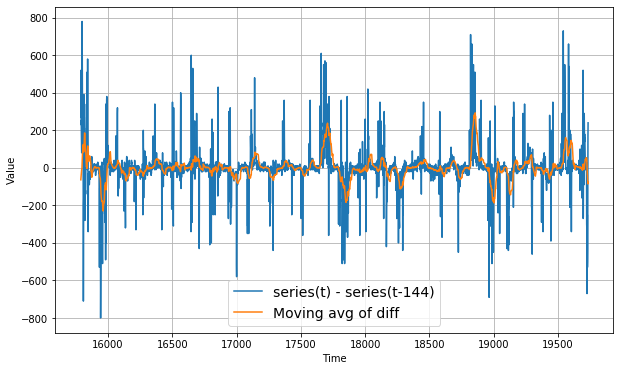

In [38]:
diff_moving_avg = moving_average(diff_series, 30)[split_time - 144 - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 144:], label = "series(t) - series(t-144)")
plot_series(time_valid, diff_moving_avg, label = "Moving avg of diff")
plt.show()

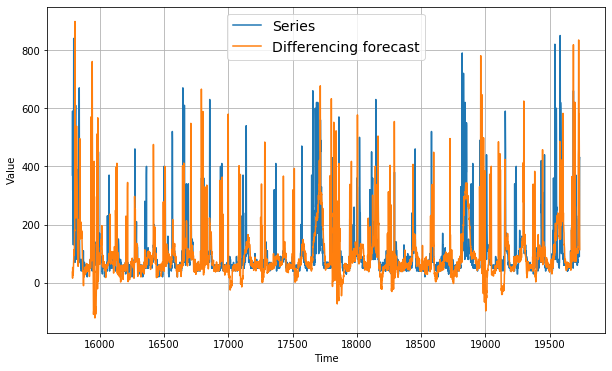

In [39]:
diff_moving_avg_plus_past = series[split_time - 144: -144] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Differencing forecast")
plt.show()

In [40]:
tf.keras.metrics.mse(x_valid, diff_moving_avg_plus_past).numpy()

11104.59637418011

In [41]:
tf.keras.metrics.mae(x_valid, diff_moving_avg_plus_past).numpy()

55.2911916223292

* Worst

* Differencing follow the logic in the moving avg strategy. If you find difficult to understand, make sure to check the naive forecast method, which may help.

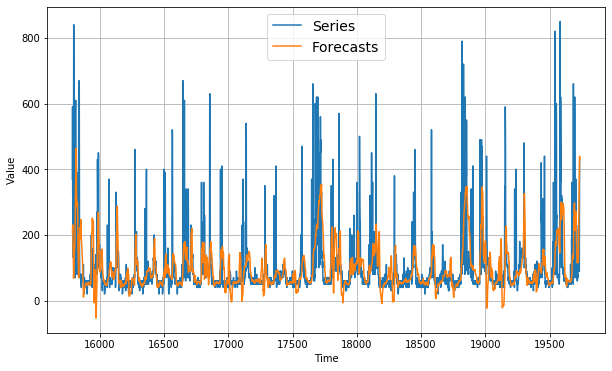

In [42]:
# eliminating part of the noise in differencing
diff_moving_avg_plus_smooth_past = moving_average(series[split_time - 144 - 10: -144], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [43]:
tf.keras.metrics.mse(x_valid, diff_moving_avg_plus_smooth_past).numpy()

7076.762323001998

In [44]:
tf.keras.metrics.mae(x_valid, diff_moving_avg_plus_smooth_past).numpy()

45.44903302085973

* Better than the previous one but still worse than naive approach (which is our baseline)